# Photon added states without adding a photon

Author: Nicolás Quesada 

In this tutorial we study how to prepare photon added states following the ideas from 
"Generating photon-added states without adding a photon" [Phys. Rev. A 100, 043802 (2019)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.100.043802) by S.U. Shringarpure and J.D. Franson.

In [1]:
import numpy as np
from qutip import wigner, Qobj, wigner_cmap, qfunc

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import strawberryfields as sf
from strawberryfields.ops import *
from thewalrus.quantum import state_vector, density_matrix

## Ideal preparation

Here we setup some basic parameters, like the value of the photon-number-resolving detectors we will use to herald and the amount of squeezing and displacement to use. These parameters are taken from the reference cited above.

In [2]:
# the Fock state measurement of mode 0 to be post-selected
m1 = 1
# the Fock state measurement of mode 1 to be post-selected
m2 = 1
r1 = np.arcsinh(1.0)
g = 1.195
r2 = np.arccosh(g)
alpha = 2.0

Their circuit requires as input a single photon. We cannot prepare single photons directly using only Gaussian resources, but they can be generated by heralding one half of a two-mode squeezed vacuum. We do this by applying a two-mode squeezing gate in modes 1 and 2 and then heralding mode 2 in a single photon event later on.
Note that the value of the gain `g` is picked to match the parameters from figure 5.(d) of Shringarpure and Franson's paper. However one can change this value to match any other parameter setting studied in their paper.

Now we setup a 3-mode quantum circuit in Strawberry Fields and obtain the covariance matrix and vector of means of the Gaussian state

In [3]:
nmodes = 3
prog = sf.Program(nmodes)
eng = sf.Engine("gaussian")
with prog.context as q:
    S2gate(r1)|(q[1],q[2])
    Dgate(alpha)|q[0]
    S2gate(r2)|(q[0],q[1])
state = eng.run(prog).state
mu = state.means()
cov = state.cov()

In [4]:
# Here we use the sf circuit drawer and standard linux utilities 
# to generate an svg representing the circuit
file, _ = prog.draw_circuit()
filepdf = file[0:-3]+"pdf"
filepdf = filepdf.replace("circuit_tex/","")
filecrop = filepdf.replace(".pdf","-crop.pdf")
name = "added_circuit.svg"
!pdflatex  $file > /dev/null 2>&1
!pdfcrop $filepdf > /dev/null 2>&1
!pdf2svg $filecrop $name

Here is a graphical representation of the circuit. It is always assumed that the input is vacuum in all the modes. <br>
![img](./added_circuit.svg)

We can now inspect the covariance matrix and vector of means. Note that the vector of means is non-zero since we did use displacement gates in the circuit above.

In [5]:
print(np.round(mu,10))
print(np.round(cov,10))

[ 4.78        2.61694478  0.          0.         -0.          0.        ]
[[ 2.7121      3.12724902  1.8504594   0.         -0.          0.        ]
 [ 3.12724902  4.7121      3.37997041 -0.          0.         -0.        ]
 [ 1.8504594   3.37997041  3.          0.         -0.          0.        ]
 [ 0.         -0.          0.          2.7121     -3.12724902  1.8504594 ]
 [-0.          0.         -0.         -3.12724902  4.7121     -3.37997041]
 [ 0.         -0.          0.          1.8504594  -3.37997041  3.        ]]


We now use The Walrus to obtain the Fock representation of the heralded Gaussian state when mode 1 is heralded in the value $n=1$ in the variable `psi`. We also calculate the probability of success in heralding in the variable `p_psi`.

In [6]:
cutoff = 20
psi = state_vector(mu, cov, post_select={1: m1, 2: m2}, normalize=False, cutoff=cutoff)
p_psi = np.linalg.norm(psi)
psi = psi/p_psi
print("The probability of successful heralding is ", np.round(p_psi**2,5))

The probability of successful heralding is  0.02043


We now plot the photon-number distribution of the heralded state. Note that the state has zero support on the Fock state with $i=2$ photons.

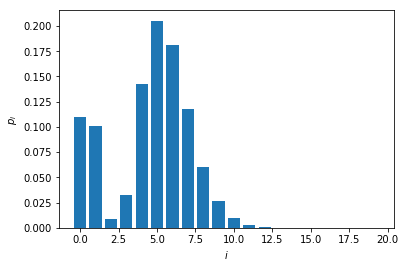

In [7]:
plt.bar(np.arange(cutoff),np.abs(psi)**2)
plt.xlabel("$i$")
plt.ylabel(r"$p_i$")
plt.show()

We can plot the Q function and compare it with figure 5.(d) of their manuscript:

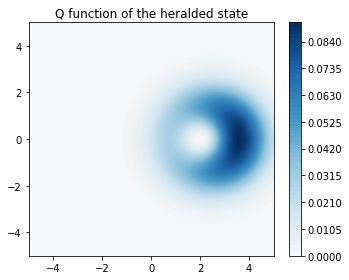

In [8]:
grid = 100
xvec = np.linspace(-5,5,grid)
Q = qfunc(Qobj(psi), xvec, xvec)
wmap = wigner_cmap(Q)
sc1 = np.max(Q)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
plt1 = axes.contourf(xvec, xvec, Q, 60,  cmap=cm.RdBu, norm=nrm)
axes.contour(xvec, xvec, Q, 60,  cmap=cm.RdBu, norm=nrm)
axes.set_title("Q function of the heralded state");
cb1 = fig.colorbar(plt1, ax=axes)
fig.tight_layout()
plt.show()

We can now plot the Wigner function of the heralded state,

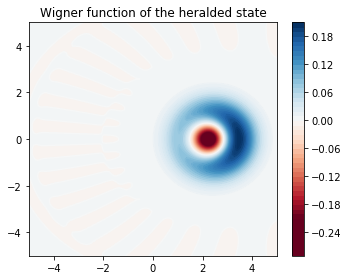

In [9]:
grid = 100
xvec = np.linspace(-5,5,grid)
Wp = wigner(Qobj(psi), xvec, xvec)
wmap = wigner_cmap(Wp)
sc1 = np.max(Wp)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
plt1 = axes.contourf(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.contour(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.set_title("Wigner function of the heralded state");
cb1 = fig.colorbar(plt1, ax=axes)
fig.tight_layout()
plt.show()

and a cut of the Wigner function along $p=0$.

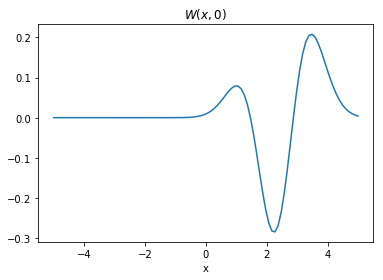

In [10]:
plt.plot(xvec, Wp[grid//2,:])
plt.title(r"$W(x,0)$")
plt.xlabel(r"x")
plt.show()

## Adding Loss

We can now study what happens when loss in the heralding arm is increased. We will add loss in the heralding arm by varying the efficiency of the detector which is parametrized by a transmission $\eta$ ranging from $\eta = 50\%$ to $\eta = 100\%$ (ideal operation).

In [11]:
eta_vals = np.arange(1.,0.45,-0.05)
fidelities = np.zeros_like(eta_vals, dtype=complex)
success_p = np.zeros_like(eta_vals, dtype=complex)
nmodes = 3
for i,eta in enumerate(eta_vals):
    prog = sf.Program(nmodes)
    eng = sf.Engine("gaussian")
    with prog.context as q:
        S2gate(r1)|(q[1],q[2])
        Dgate(alpha)|q[0]
        S2gate(r2)|(q[0],q[1])
        LossChannel(eta)|q[1]
        LossChannel(eta)|q[2]
    state = eng.run(prog).state
    mu = state.means()
    cov = state.cov()
    rho = density_matrix(mu, cov, post_select={1: m1, 2: m2}, normalize=False, cutoff=cutoff)
    success_p[i] = np.trace(rho)
    fidelities[i] = psi.conj() @ rho @ psi/success_p[i]

We now plot the probability of success of the heralding scheme as a function of the transmission,

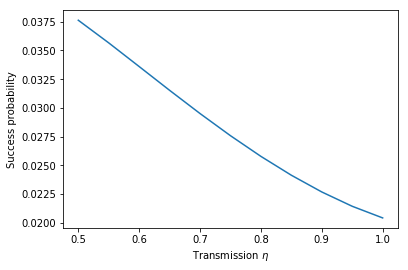

In [12]:
plt.plot(eta_vals, success_p.real)
plt.xlabel(r"Transmission $\eta$")
plt.ylabel(r"Success probability")
plt.show()

and similarly study the fidelity of the heralded state with respect to the ideal (lossless) state.

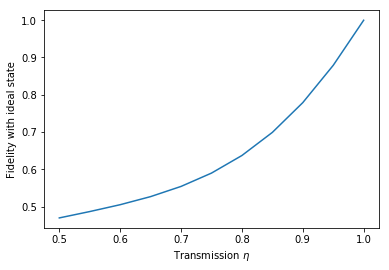

In [13]:
plt.plot(eta_vals, fidelities.real)
plt.xlabel(r"Transmission $\eta$")
plt.ylabel(r"Fidelity with ideal state")
plt.show()

We can also look at the photon number distribution of the nonideal state.

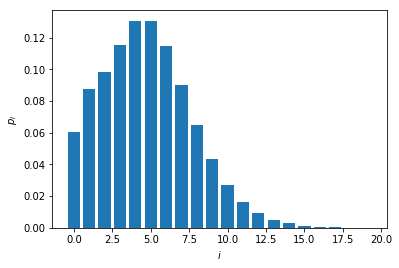

In [14]:
plt.bar(np.arange(cutoff),np.real(np.diag(rho/np.trace(rho))))
plt.xlabel(r"$i$")
plt.ylabel(r"$p_i$")
plt.show()

Now we plot the Wigner function of the heralded state for $\eta = 50\%$

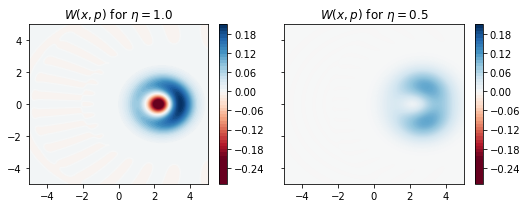

In [15]:
sc1 = np.max(Wp)
W = wigner(Qobj(rho/np.trace(rho)), xvec, xvec)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3),sharey=True)
axes[0].contourf(xvec, xvec, Wp, 60,cmap=cm.RdBu, norm=nrm)
axes[0].contour(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes[0].set_title(r"$W(x,p)$ for $\eta = 1.0$");
cb1 = fig.colorbar(plt1, ax=axes[0])
plt2 = axes[1].contourf(xvec, xvec, W ,60, cmap=cm.RdBu, norm=nrm)  
plt2 = axes[1].contour(xvec, xvec, W ,60, cmap=cm.RdBu, norm=nrm)  
axes[1].set_title(r"$W(x,p)$ for $\eta = 0.5$");
cb2 = fig.colorbar(plt1, ax=axes[1])
fig.tight_layout()
plt.show()

and also a cut of the Wigner function along $x=0$

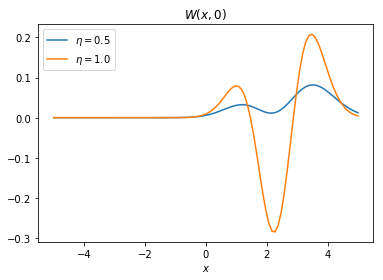

In [16]:
plt.plot(xvec, W[grid//2,:], label=r"$\eta=0.5$")
plt.plot(xvec, Wp[grid//2,:], label=r"$\eta=1.0$")
plt.title(r"$W(x,0)$")
plt.xlabel(r"$x$")
plt.legend()
plt.show()

In [17]:
%reload_ext version_information
%version_information qutip, strawberryfields, thewalrus

Software versions
Python 3.6.8 64bit [GCC 7.3.0]
IPython 7.4.0
OS Linux 4.4.0 89 generic x86_64 with debian stretch sid
qutip 4.4.1
strawberryfields 0.10.0
thewalrus 0.11.0-dev
Fri Dec 27 22:41:16 2019 EST